In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
# importlib.reload(trades)
# importlib.reload(plots)
# importlib.reload(params)
# importlib.reload(models)

import sys
print(sys.executable)

import math
import pandas as pd
from pandas import Timestamp
import numpy as np
import glob
import os
import json

import datetime as dt
from datetime import datetime
from pprint import pprint
from collections import OrderedDict

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import display, HTML
import seaborn as sns

from typing import Optional, Dict, Tuple, List, Sequence
from sklearn.preprocessing import StandardScaler

from tqdm.auto import tqdm
tqdm.pandas()        

pd.set_option('display.max_columns', None)


/usr/bin/python


[main] Found existing base CSV: dfs_training/AAPL_1_base.csv


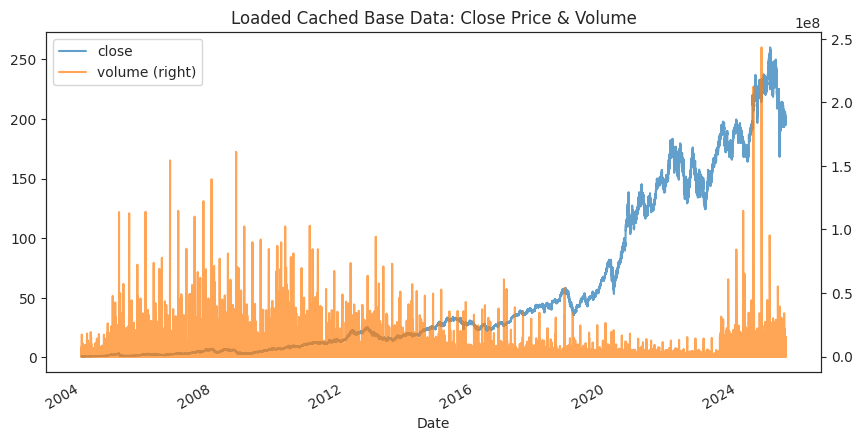

open        high         low       close  \
2004-01-02 09:00:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:01:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:02:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:03:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:04:00    0.764286    0.764286    0.764286    0.764286   
...                         ...         ...         ...         ...   
2025-06-18 20:56:00  196.680000  196.860000  196.630000  196.815000   
2025-06-18 20:57:00  196.810000  196.940000  196.560000  196.675000   
2025-06-18 20:58:00  196.675000  196.740000  196.630000  196.670000   
2025-06-18 20:59:00  196.680000  196.750000  196.240000  196.240000   
2025-06-18 21:00:00  196.580000  196.650000  196.080000  196.540000   

                         volume         ask         bid  
2004-01-02 09:00:00     28000.0    0.764857    0.763714  
2004-01-02 09:01:00     28000.0    0.764857    0.763714  
2004-01-02 09:02:00     28000.0    0.764857    0.763714  
2004-01-02 09:03:00     28000.0    0.764857    0.763714  
2004-01-02 09:04:00     28000.0    0.764857    0.763714  
...                         ...         ...         ...  
2025-06-18 20:56:00    385695.0  196.962600  196.667400  
2025-06-18 20:57:00    460630.0  196.822500  196.527500  
2025-06-18 20:58:00    525245.0  196.817500  196.522500  
2025-06-18 20:59:00   2075503.0  196.387200  196.092800  
2025-06-18 21:00:00  15600625.0  196.687400  196.392600  

[3893400 rows x 7 columns]

In [2]:
base_csv = params.base_csv

if os.path.exists(base_csv):
    # -----------------------------------------------------------------
    # 1) Cached file exists → load it, plot it, skip all processing.
    # -----------------------------------------------------------------
    print(f"[main] Found existing base CSV: {base_csv}")
    df = pd.read_csv(base_csv, index_col=0, parse_dates=True)
    plots.plot_close_volume(
        df,
        title="Loaded Cached Base Data: Close Price & Volume"
    )

else:
    # -----------------------------------------------------------------
    # 2) No cached file → do the full split‐adjust and then minute‐grid prep
    # -----------------------------------------------------------------
    print(f"[main] No base CSV found; running process_splits …")
    df_raw = trades.process_splits(
        folder              = params.stocks_folder,
        ticker              = params.ticker,
        bidasktoclose_pct   = params.bidasktoclose_pct
    )

    # Once‐only minute grid build and interpolation
    print(f"[main] Running prepare_interpolate_data …")
    df = trades.prepare_interpolate_data(
        df                = df_raw,
        sess_premark      = params.sess_premark,
        sess_start        = params.sess_start,
        sess_end          = params.sess_end
    )
    
    # Persist to base CSV and return
    df.to_csv(base_csv)
    print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [3]:
def process_single_day(day_str: str, best_optuna_params: dict):
    """
    Process and plot a single trading session using a given set of hyperparameters.

    Returns:
      Tuple[pd.DataFrame, Dict] | None
        If a valid backtest runs, returns (df_day, perf_day).
        If no data or no trades, returns None.
    """
    print(f"\n=== Processing trading day {day_str} ===")
    day_dt = pd.to_datetime(day_str)
    # Extract that day’s full-minute bars from the master df
    day_df = df.loc[df.index.normalize() == day_dt].copy()
    if day_df.empty:
        print(" no data; skipping.")
        return

    print("\n Running trading pipeline on selected date …")
    # Call run_trading_pipeline with your per-day slice + EXACTLY the same best_optuna_params
    result = trades.run_trading_pipeline(
                                        df                       = day_df,
                                        col_signal               = 'signal',
                                        col_action               = 'signal_action',
                                        day_to_check             = day_str,
                                        **best_optuna_params            # unpack tuned parameters here
    )
    if result is None:
        print(" no trades found; skipping.")
        return

    # Unpack pipeline output: (df_signals, trades_list, performance_stats)
    df_day, trades_day, perf_day = result

    # Plot the equity & trade markers
    plots.plot_trades(
                    df                 = df_day,
                    col_signal1        = 'signal',
                    col_signal2        = False,
                    col_action         = 'signal_action',
                    trades             = trades_day,
                    buy_threshold      = best_optuna_params['buy_threshold'],
                    performance_stats  = perf_day,
                    start_plot         = params.sess_start # or sess_premark 
    )

    # Print the per-day summary
    print(f"\n* Performance for {day_dt.date()} *")
    for k, v in perf_day.items():
        print(f"  {k}: {v}")

    return df_day, perf_day


In [4]:
def saveDF_checkDAY(df: pd.DataFrame, best_optuna_params: dict):
    """
    Backtest in two modes and optionally save a full‐run CSV of signals,
    using the supplied hyperparameters.

    Modes:
      • Month mode (params.date_to_check = 'YYYY-MM'):
          – process each trading day via process_single_day(..., best_optuna_params)
          – plot monthly aggregate performance
          – return the month’s concatenated DataFrame (empty if none)

      • Full‐run mode (params.createCSVsign == True):
          – run the identical pipeline used by Optuna over all days
            with **best_optuna_params
          – compute & print the full‐period summary
          – plot full‐period performance
          – isolate & compute the test‐period summary
          – plot test‐period performance
          – save the dataframe with the calculated signal
          – return the full‐run DataFrame
    """
    keep_cols = [
        "open","high","low","close",
        "volume","bid","ask",
        "StrategyEarning","EarningDiff",
        "signal","signal_action"
    ]

    # ── Month mode ────────────────────────────────────────────────────
    print(f"\nMonth mode: processing {params.date_to_check}")
    month_days = (
                df.loc[df.index.strftime("%Y-%m") == params.date_to_check]
                  .index.normalize()
                  .unique()
    )

    month_frames, month_stats = [], []
    for day in sorted(month_days):
        # Pass best_optuna_params into process_single_day
        res = process_single_day(day_str = str(day.date()), 
                                 best_optuna_params = best_optuna_params)
        
        if res is None:
            continue
        df_day, stats = res
        month_frames.append(df_day)
        month_stats.append(stats)

    if not month_frames:
        print("No valid days in this month.")
        return pd.DataFrame(columns=keep_cols)

    df_month = pd.concat(month_frames).sort_index()
    plots.aggregate_performance(month_stats, df_month)

    # If we aren’t saving a full-run CSV, bail out
    if not params.createCSVsign:
        return df_month

    # ── Full‐run mode ────────────────────────────────────────────────
    print("\nFull‐run mode")
    print("• Running trading pipeline on full dataset …")
    # Unpack best_optuna_params into run_trading_pipeline exactly as in Optuna
    full_sim_results = trades.run_trading_pipeline(
                                                    df            = df,
                                                    col_signal    = 'signal',
                                                    col_action    = 'signal_action',
                                                    **best_optuna_params
    )

    # 1) Build combined DF & perf list (zeros on no‐trade days)
    daily_frames = [res[0][keep_cols] for res in full_sim_results.values()]
    df_all       = pd.concat(daily_frames).sort_index()
    perf_all     = [res[2] for res in full_sim_results.values()]

    # 2) Print & plot full‐period performance using df_all
    print("\nFull‐period performance:")
    plots.aggregate_performance(perf_all, df_all)

    # 3) Test‐period slice & plot
    days_all  = df_all.index.normalize().unique()
    cutoff    = int(len(days_all) * (params.train_prop + params.val_prop))
    test_days = days_all[cutoff:]
    df_test   = df_all[df_all.index.normalize().isin(test_days)]
    perf_test = [
        stats
        for day, (_, _, stats) in full_sim_results.items()
        if pd.Timestamp(day).normalize() in test_days
    ]

    print("\nTest‐period performance:")
    plots.aggregate_performance(perf_test, df_test)

    # Save the full-run signals CSV
    print("\n• Saving signals CSV …")
    df_all.to_csv(params.sign_csv)
    print(f"Saved to {params.sign_csv}")

    return df_all


best_optuna_value: 0.45608055555555554
best_optuna_params: {'min_prof_thr': 0.04190263343991938, 'max_down_prop': 0.3254692616047628, 'gain_tightening_factor': 3.165934190339374, 'merging_retracement_thr': 0.16180862452622266, 'merging_time_gap_thr': 1.5985281794270567, 'pre_entry_decay': 0.015629113426371334, 'short_penal_decay': 2.326244111557537, 'trailing_stop_pct': 0.062337473464865095, 'buy_threshold': 0.11872532788885932, 'top_percentile': 0.9805406429949215, 'smoothing_window': 2}

Month mode: processing 2024-06

=== Processing trading day 2024-06-03 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 1/1 [00:00<00:00, 38.32day/s]


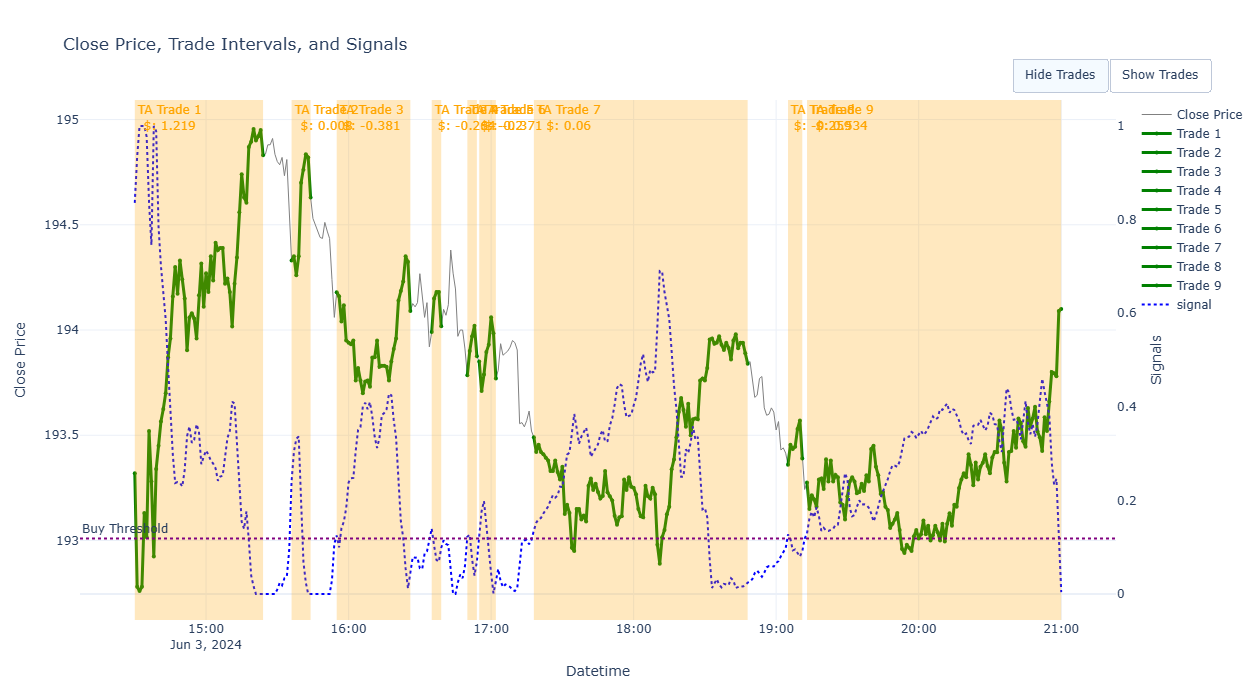


* Performance for 2024-06-03 *
  Buy & Hold Return ($): 0.489
  Strategy Return ($): 0.346
  Trades Returns ($): [1.219, 0.008, -0.381, -0.264, -0.2, -0.371, 0.06, -0.259, 0.534]

=== Processing trading day 2024-06-04 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 1/1 [00:00<00:00, 29.81day/s]


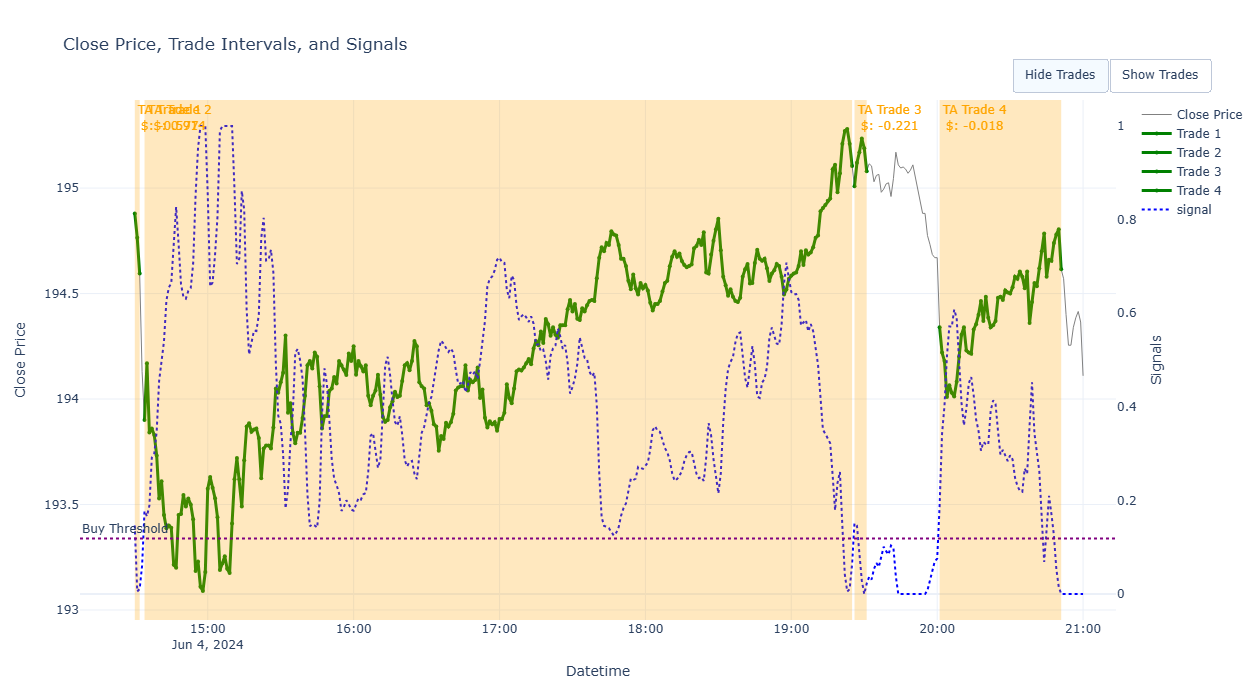


* Performance for 2024-06-04 *
  Buy & Hold Return ($): -1.062
  Strategy Return ($): 0.099
  Trades Returns ($): [-0.577, 0.914, -0.221, -0.018]

=== Processing trading day 2024-06-05 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 1/1 [00:00<00:00, 34.42day/s]


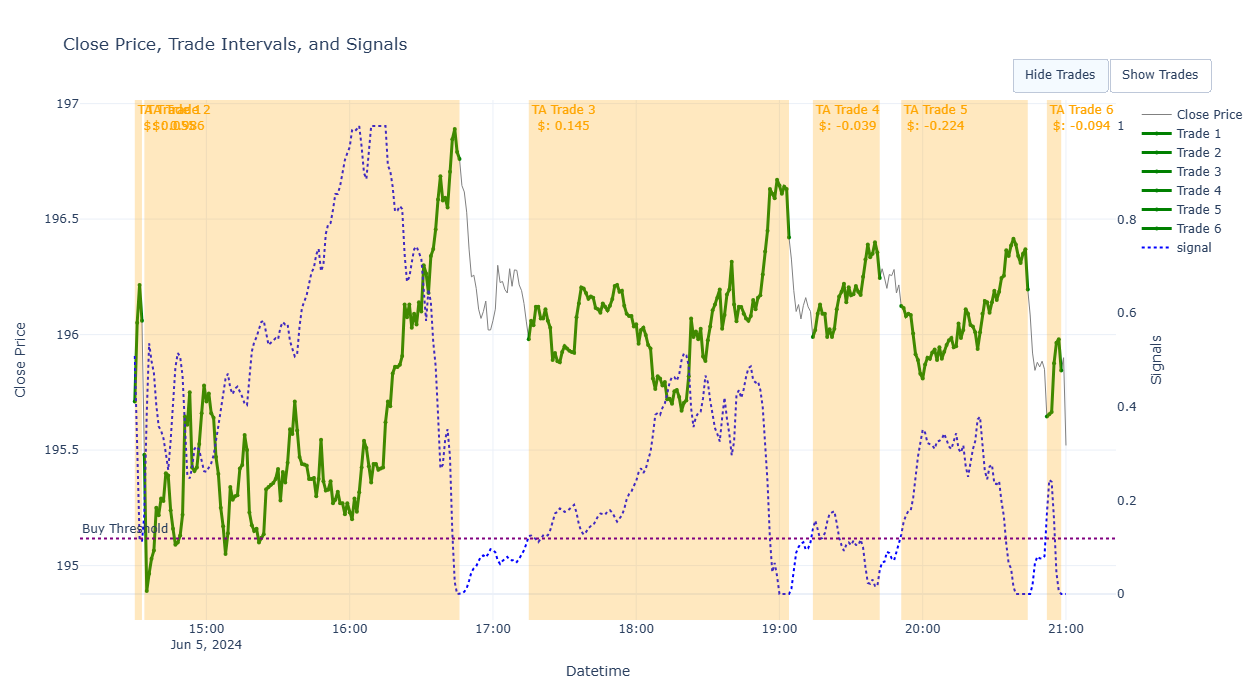


* Performance for 2024-06-05 *
  Buy & Hold Return ($): -0.484
  Strategy Return ($): 0.831
  Trades Returns ($): [0.055, 0.986, 0.145, -0.039, -0.224, -0.094]

=== Processing trading day 2024-06-06 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 1/1 [00:00<00:00, 38.93day/s]


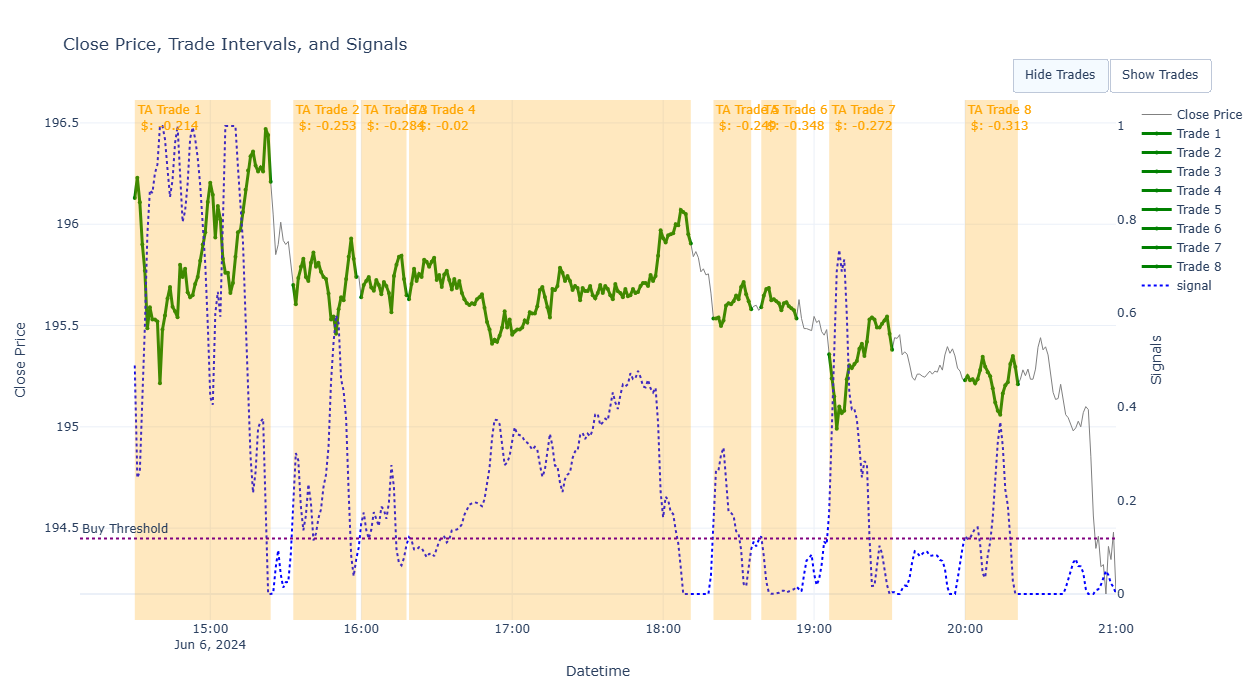


* Performance for 2024-06-06 *
  Buy & Hold Return ($): -2.243
  Strategy Return ($): -1.951
  Trades Returns ($): [-0.214, -0.253, -0.284, -0.02, -0.249, -0.348, -0.272, -0.313]

=== Processing trading day 2024-06-07 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 1/1 [00:00<00:00, 38.08day/s]


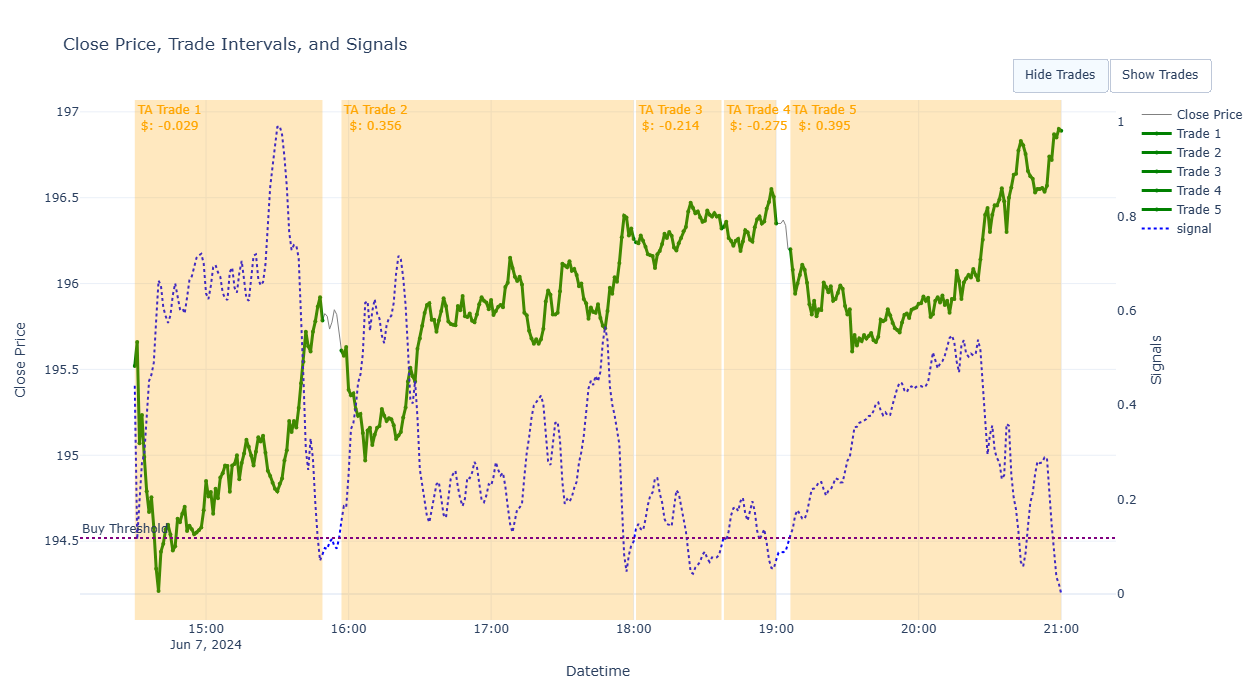


* Performance for 2024-06-07 *
  Buy & Hold Return ($): 1.076
  Strategy Return ($): 0.234
  Trades Returns ($): [-0.029, 0.356, -0.214, -0.275, 0.395]

=== Processing trading day 2024-06-10 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 1/1 [00:00<00:00, 29.73day/s]


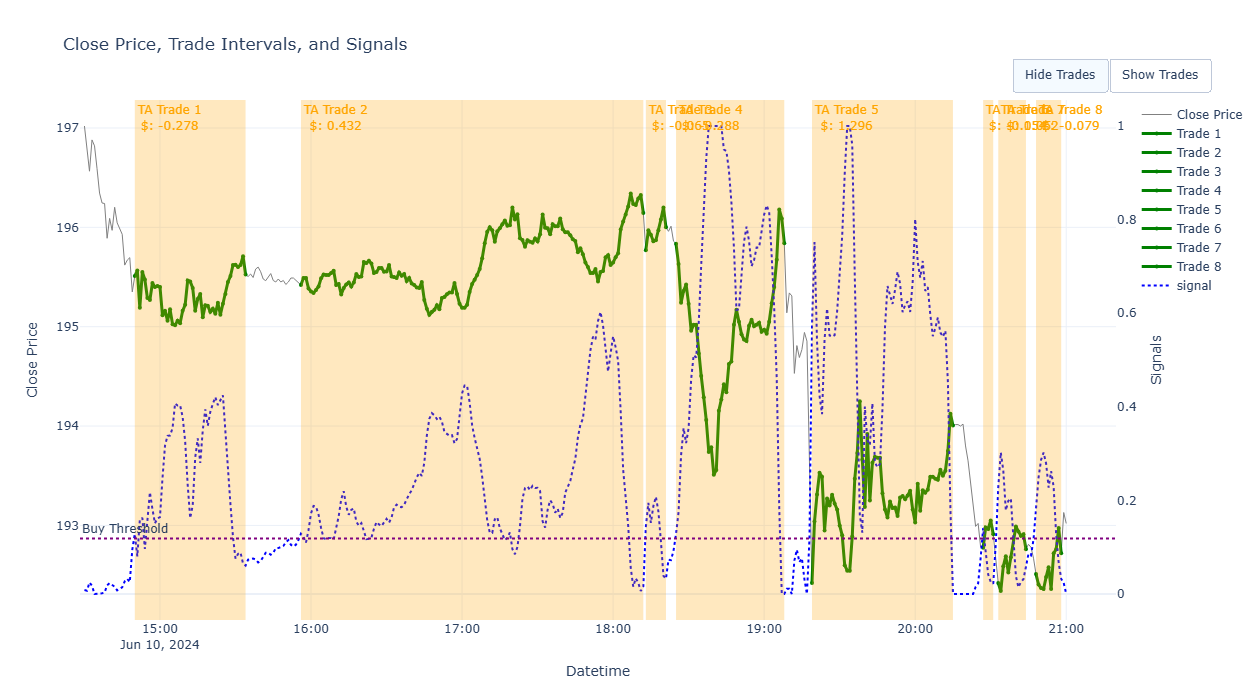


* Performance for 2024-06-10 *
  Buy & Hold Return ($): -4.293
  Strategy Return ($): 0.914
  Trades Returns ($): [-0.278, 0.432, -0.065, -0.288, 1.296, -0.154, 0.052, -0.079]

=== Processing trading day 2024-06-11 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 1/1 [00:00<00:00, 26.57day/s]


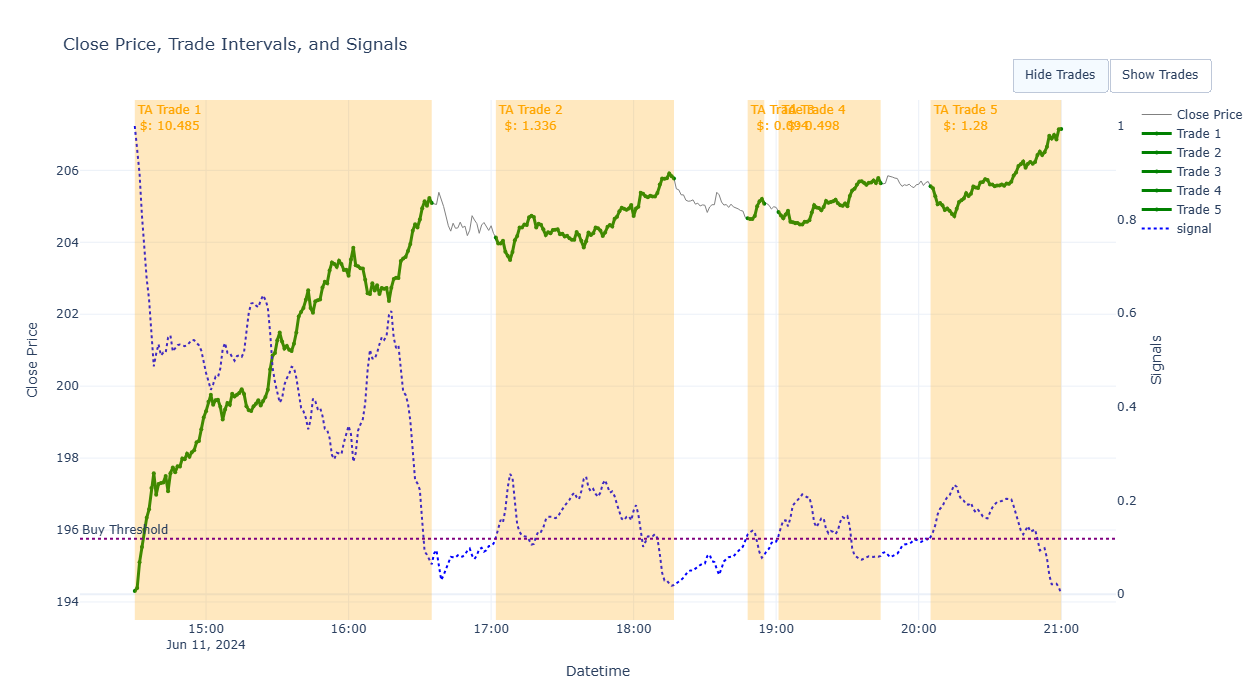


* Performance for 2024-06-11 *
  Buy & Hold Return ($): 12.544
  Strategy Return ($): 13.695
  Trades Returns ($): [10.485, 1.336, 0.094, 0.498, 1.28]

=== Processing trading day 2024-06-12 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 1/1 [00:00<00:00, 32.11day/s]


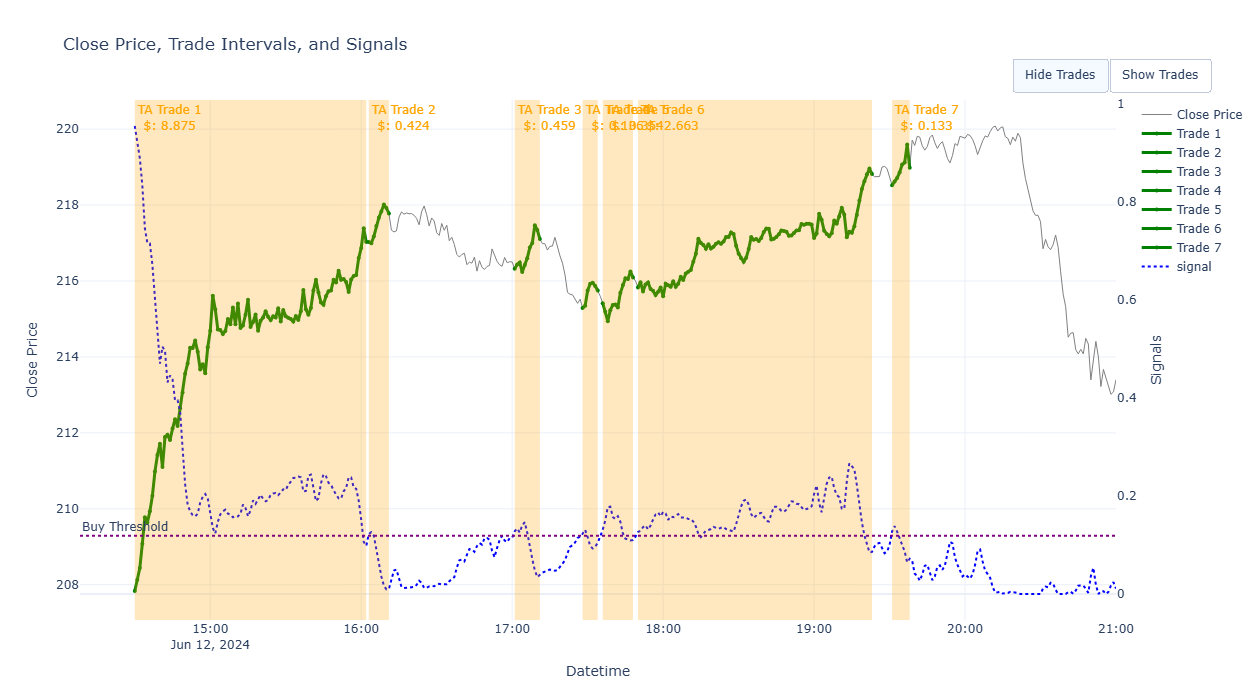


* Performance for 2024-06-12 *
  Buy & Hold Return ($): 5.249
  Strategy Return ($): 13.045
  Trades Returns ($): [8.875, 0.424, 0.459, 0.136, 0.354, 2.663, 0.133]

=== Processing trading day 2024-06-13 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 1/1 [00:00<00:00, 37.09day/s]


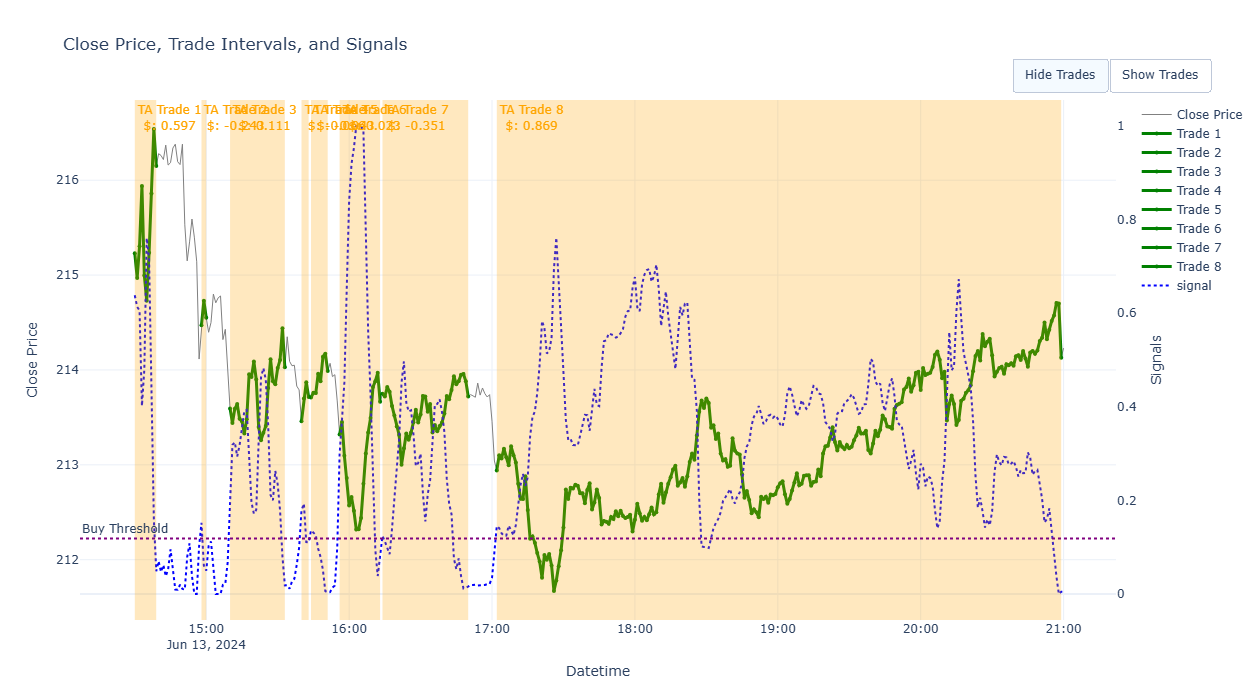


* Performance for 2024-06-13 *
  Buy & Hold Return ($): -1.322
  Strategy Return ($): 0.903
  Trades Returns ($): [0.597, -0.243, 0.111, -0.066, -0.043, 0.023, -0.351, 0.869]

=== Processing trading day 2024-06-14 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 1/1 [00:00<00:00, 33.00day/s]


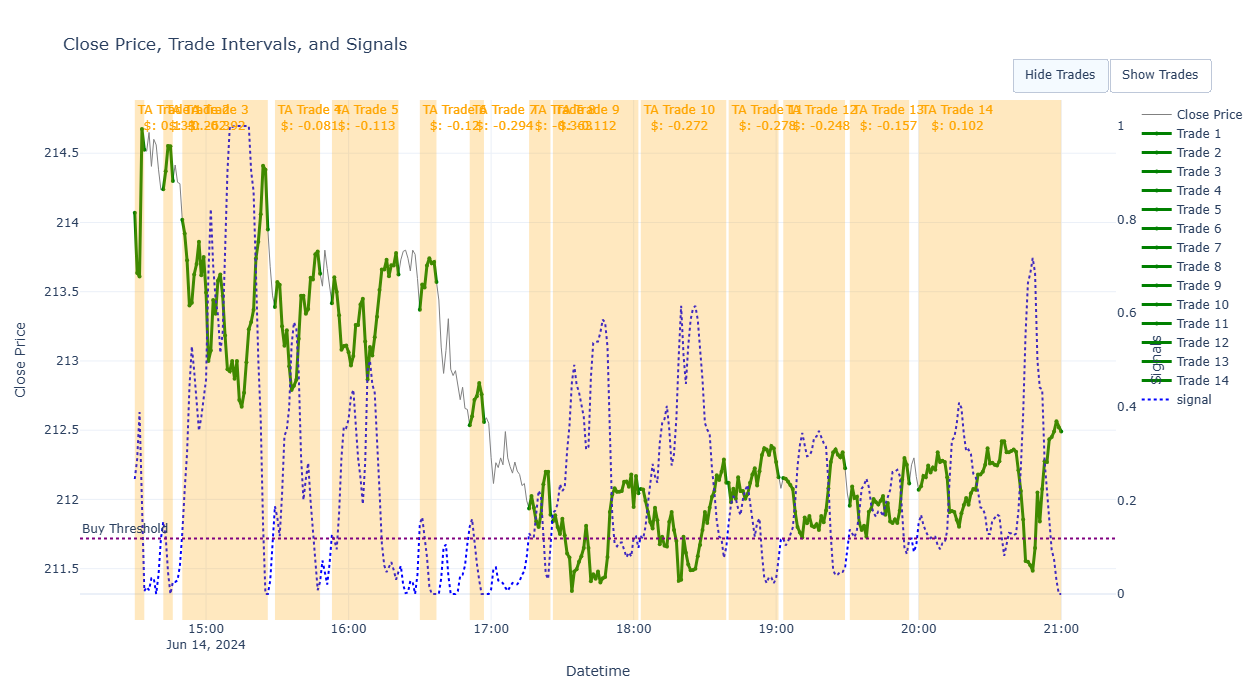


* Performance for 2024-06-14 *
  Buy & Hold Return ($): -1.9
  Strategy Return ($): -2.457
  Trades Returns ($): [0.133, -0.262, -0.392, -0.081, -0.113, -0.12, -0.294, -0.363, -0.112, -0.272, -0.278, -0.248, -0.157, 0.102]

=== Processing trading day 2024-06-17 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 1/1 [00:00<00:00, 34.08day/s]


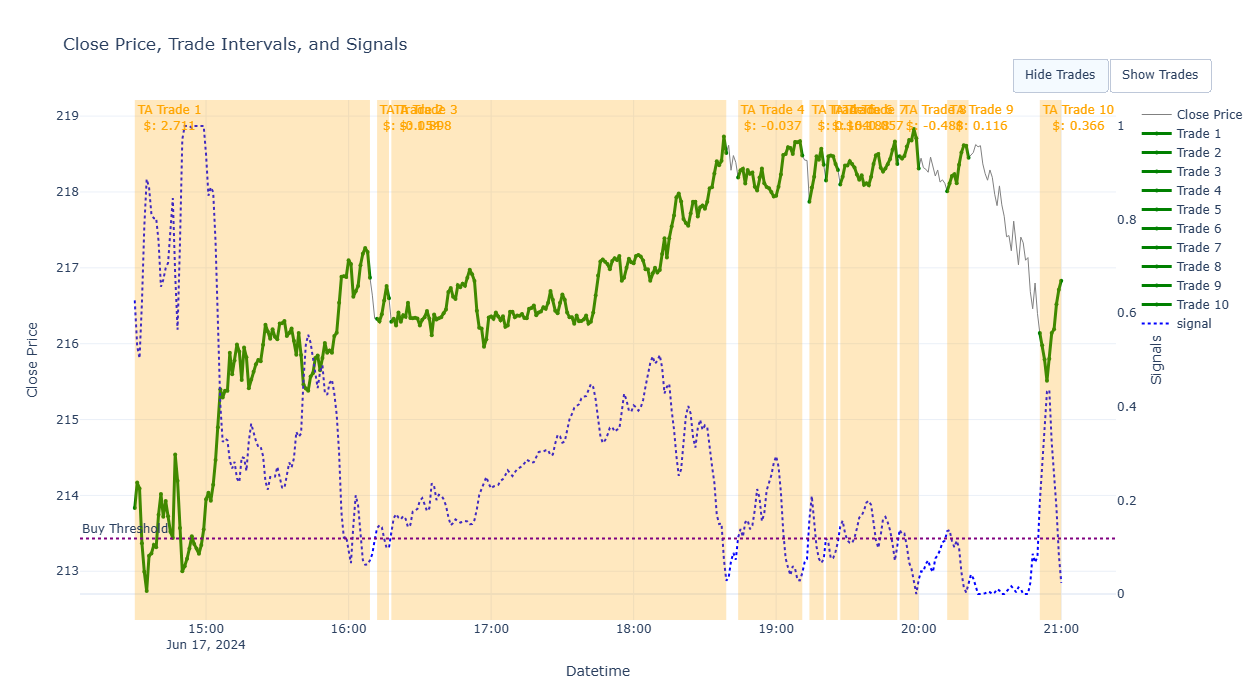


* Performance for 2024-06-17 *
  Buy & Hold Return ($): 2.672
  Strategy Return ($): 4.429
  Trades Returns ($): [2.711, -0.054, 1.898, -0.037, 0.164, -0.188, -0.057, -0.488, 0.116, 0.366]

=== Processing trading day 2024-06-18 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 1/1 [00:00<00:00, 32.35day/s]


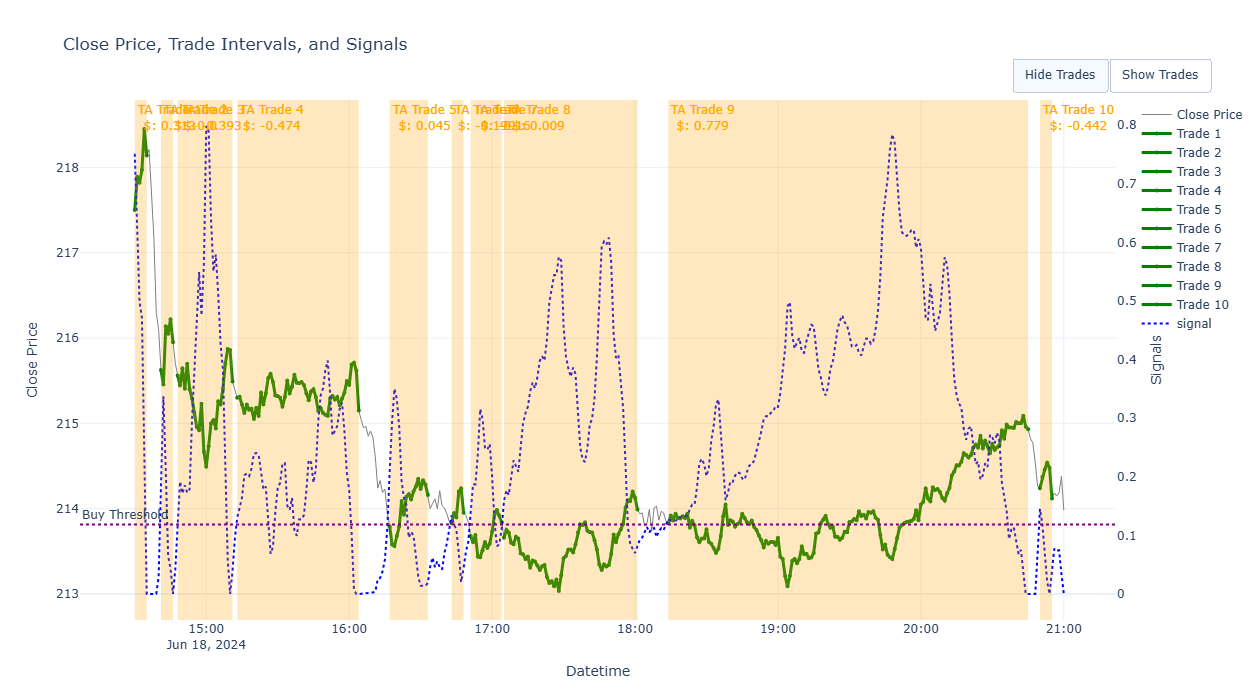


* Performance for 2024-06-18 *
  Buy & Hold Return ($): -3.844
  Strategy Return ($): -0.522
  Trades Returns ($): [0.313, -0.0, -0.393, -0.474, 0.045, -0.199, -0.16, 0.009, 0.779, -0.442]

=== Processing trading day 2024-06-20 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 1/1 [00:00<00:00, 34.46day/s]


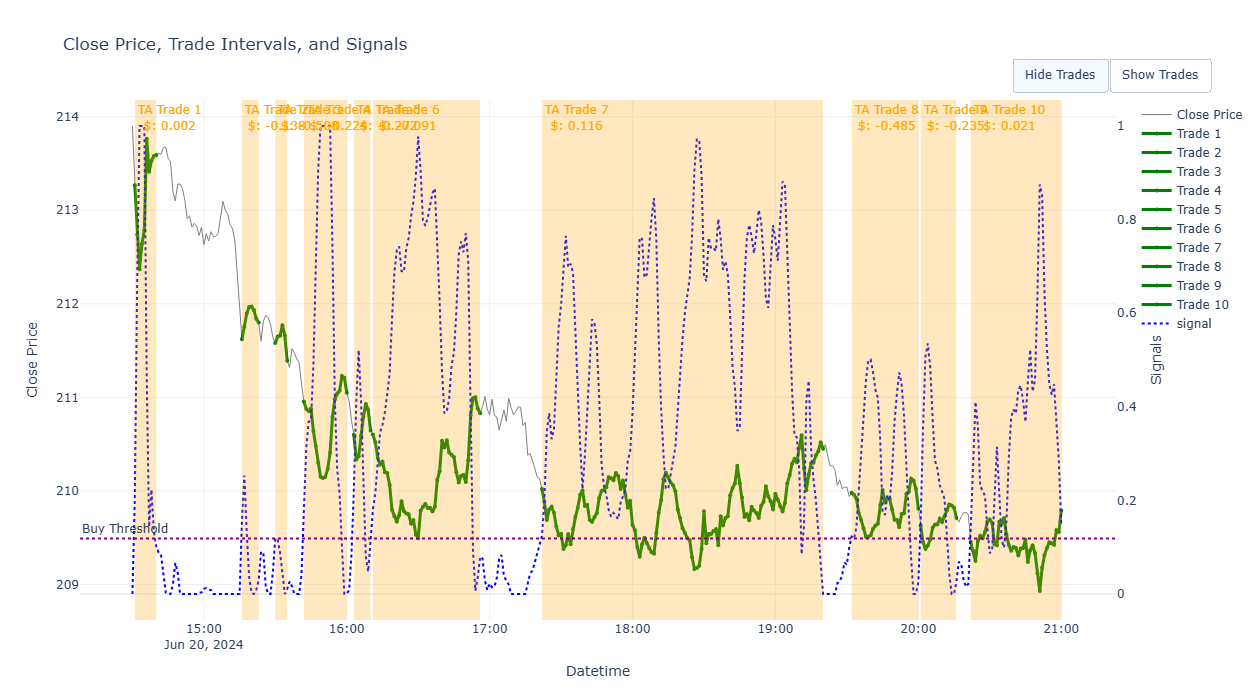


* Performance for 2024-06-20 *
  Buy & Hold Return ($): -4.428
  Strategy Return ($): -1.809
  Trades Returns ($): [0.002, -0.138, -0.508, -0.224, -0.272, -0.091, 0.116, -0.485, -0.235, 0.021]

=== Processing trading day 2024-06-21 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 1/1 [00:00<00:00, 29.47day/s]


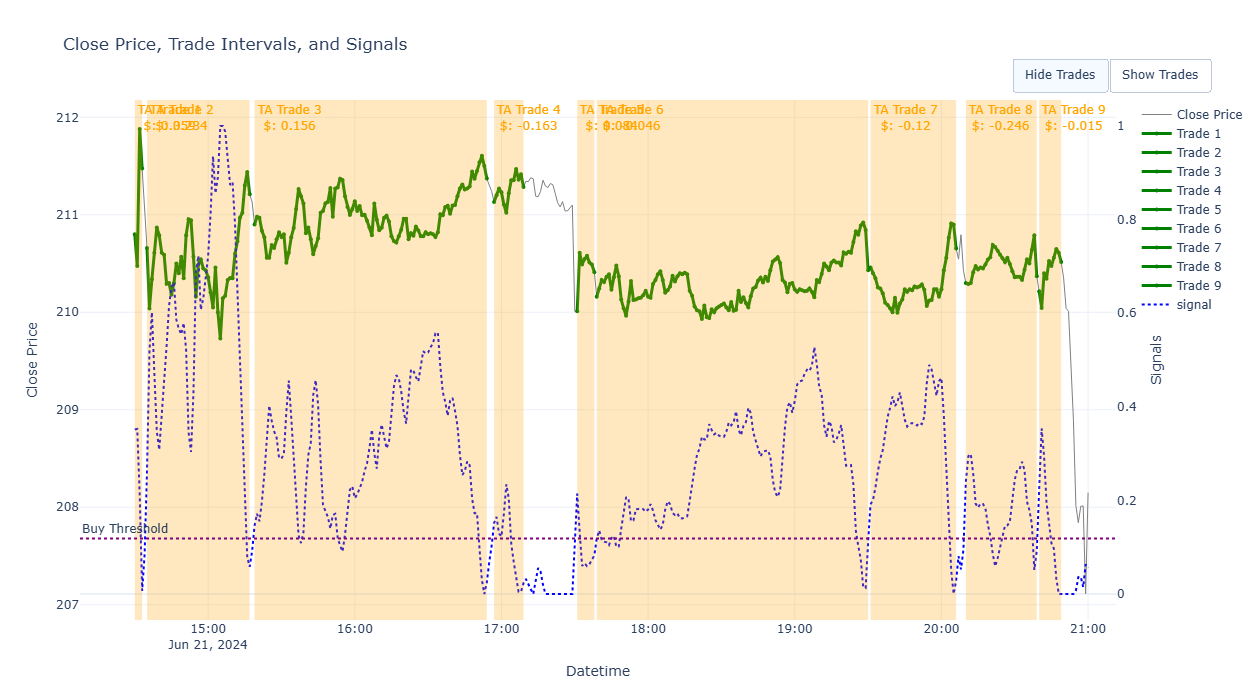


* Performance for 2024-06-21 *
  Buy & Hold Return ($): -2.964
  Strategy Return ($): 0.244
  Trades Returns ($): [0.359, 0.234, 0.156, -0.163, 0.084, -0.046, -0.12, -0.246, -0.015]

=== Processing trading day 2024-06-24 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 1/1 [00:00<00:00, 31.15day/s]


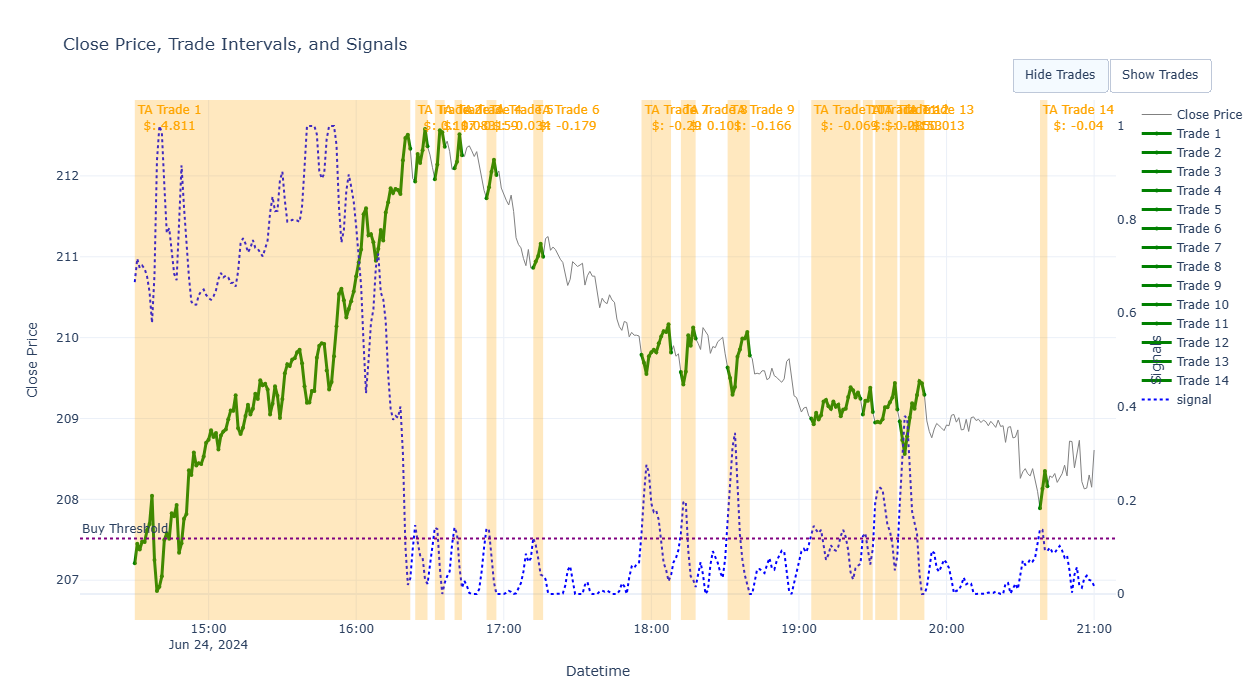


* Performance for 2024-06-24 *
  Buy & Hold Return ($): 1.088
  Strategy Return ($): 3.751
  Trades Returns ($): [4.811, 0.117, 0.083, -0.159, -0.034, -0.179, -0.29, 0.101, -0.166, -0.069, -0.285, -0.153, 0.013, -0.04]

=== Processing trading day 2024-06-25 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 1/1 [00:00<00:00, 26.87day/s]


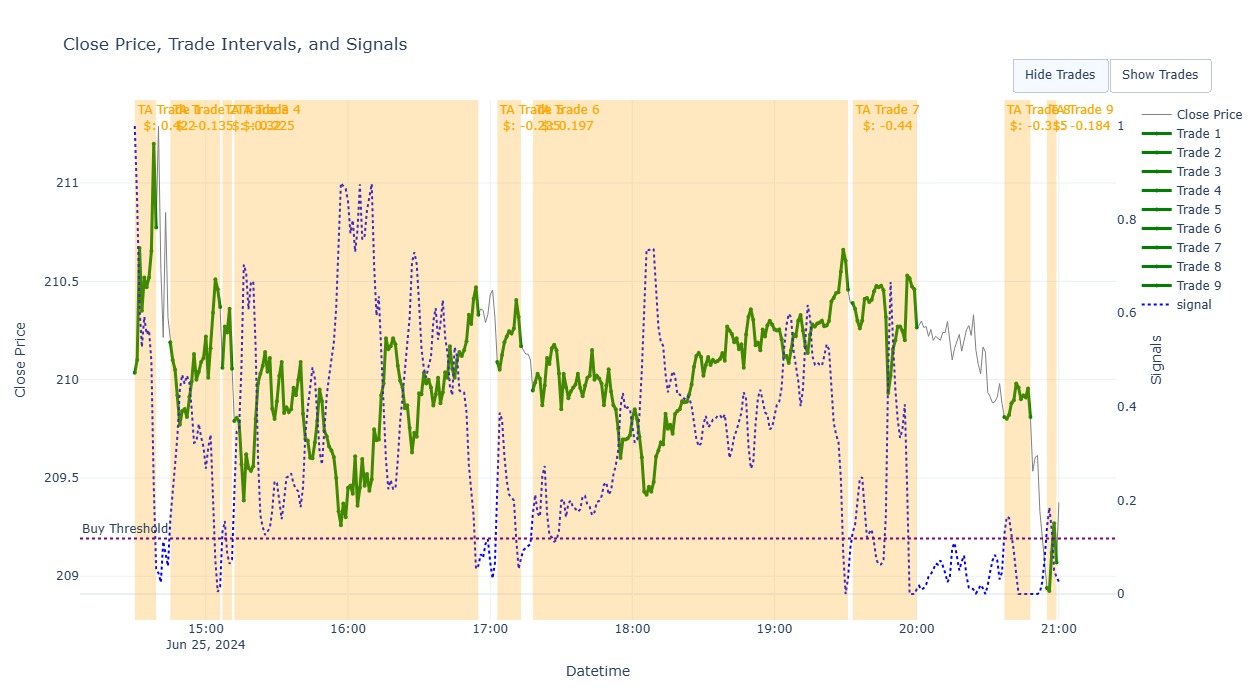


* Performance for 2024-06-25 *
  Buy & Hold Return ($): -0.975
  Strategy Return ($): -0.783
  Trades Returns ($): [0.422, -0.135, -0.32, 0.225, -0.235, 0.197, -0.44, -0.315, -0.184]

=== Processing trading day 2024-06-26 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 1/1 [00:00<00:00, 31.20day/s]



* Performance for 2024-06-26 *
  Buy & Hold Return ($): 1.446
  Strategy Return ($): 2.297
  Trades Returns ($): [2.77, -0.317, 0.579, -0.395, -0.161, -0.141, -0.038]

=== Processing trading day 2024-06-27 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 1/1 [00:00<00:00, 26.01day/s]



* Performance for 2024-06-27 *
  Buy & Hold Return ($): -1.331
  Strategy Return ($): -1.252
  Trades Returns ($): [-0.022, -0.127, -0.126, -0.03, 0.324, -0.257, -0.295, -0.415, -0.19, 0.164, -0.28]

=== Processing trading day 2024-06-28 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 1/1 [00:00<00:00, 32.05day/s]



* Performance for 2024-06-28 *
  Buy & Hold Return ($): -4.894
  Strategy Return ($): -3.159
  Trades Returns ($): [-0.616, 0.307, -0.318, -0.148, -0.421, -0.318, -0.363, -0.137, -0.205, -0.395, -0.254, -0.294]

Overall Summary (2024-06-03 = 193.4650 → 2024-06-28 = 210.4620)

One-time buy&hold gain: 16.997
Buy & Hold – each day ($): -5.176
Strategy Return ($): 28.855
Trades Count: 166
Strategy return per trade: 0.174
Num. trading days: 19
Strategy return per trading day: 1.519


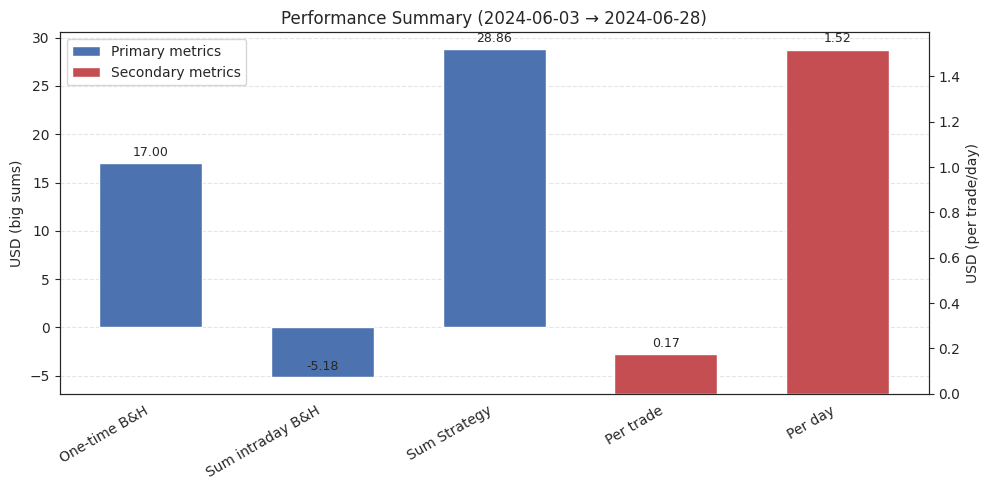

open    high       low     close      volume       ask  \
2024-06-03 09:00:00  192.45  193.14  192.4500  192.5200      3376.0  192.6644   
2024-06-03 09:01:00  192.52  192.69  192.5200  192.6000      1028.0  192.7444   
2024-06-03 09:02:00  192.60  192.78  192.6000  192.7000      6174.0  192.8445   
2024-06-03 09:03:00  192.76  192.78  192.6600  192.7400      2982.0  192.8846   
2024-06-03 09:04:00  192.77  193.05  192.7700  193.0500     13024.0  193.1948   
...                     ...     ...       ...       ...         ...       ...   
2024-06-28 20:56:00  211.03  211.30  210.8200  210.9050   1209248.0  211.0632   
2024-06-28 20:57:00  210.89  211.40  210.6888  211.2373   1114125.0  211.3957   
2024-06-28 20:58:00  211.23  211.55  210.8300  210.9600   1375474.0  211.1182   
2024-06-28 20:59:00  210.97  211.22  210.3000  210.6100   2594034.0  210.7680   
2024-06-28 21:00:00  210.80  211.39  210.3300  210.6200  40687244.0  210.7780   

                          bid    signal  signal_action  Position   Cash  \
2024-06-03 09:00:00  192.3756  0.246594              0         0  0.000   
2024-06-03 09:01:00  192.4555  0.233356              0         0  0.000   
2024-06-03 09:02:00  192.5555  0.202577              0         0  0.000   
2024-06-03 09:03:00  192.5954  0.178662              0         0  0.000   
2024-06-03 09:04:00  192.9052  0.111996              0         0  0.000   
...                       ...       ...            ...       ...    ...   
2024-06-28 20:56:00  210.7468  0.042592              0         0 -3.159   
2024-06-28 20:57:00  211.0789  0.026880              0         0 -3.159   
2024-06-28 20:58:00  210.8018  0.000000              0         0 -3.159   
2024-06-28 20:59:00  210.4520  0.000000              0         0 -3.159   
2024-06-28 21:00:00  210.4620  0.000000              0         0 -3.159   

                     NetValue    Action  TradedAmount  BuyHoldEarning  \
2024-06-03 09:00:00     0.000  No trade             0           0.000   
2024-06-03 09:01:00     0.000  No trade             0           0.000   
2024-06-03 09:02:00     0.000  No trade             0           0.000   
2024-06-03 09:03:00     0.000  No trade             0           0.000   
2024-06-03 09:04:00     0.000  No trade             0           0.000   
...                       ...       ...           ...             ...   
2024-06-28 20:56:00    -3.159      Hold             0          -4.610   
2024-06-28 20:57:00    -3.159      Hold             0          -4.278   
2024-06-28 20:58:00    -3.159      Hold             0          -4.555   
2024-06-28 20:59:00    -3.159      Hold             0          -4.904   
2024-06-28 21:00:00    -3.159  No trade             0          -4.894   

                     StrategyEarning  EarningDiff  
2024-06-03 09:00:00            0.000        0.000  
2024-06-03 09:01:00            0.000        0.000  
2024-06-03 09:02:00            0.000        0.000  
2024-06-03 09:03:00            0.000        0.000  
2024-06-03 09:04:00            0.000        0.000  
...                              ...          ...  
2024-06-28 20:56:00           -3.159        1.451  
2024-06-28 20:57:00           -3.159        1.119  
2024-06-28 20:58:00           -3.159        1.396  
2024-06-28 20:59:00           -3.159        1.745  
2024-06-28 21:00:00           -3.159        1.735  

[13699 rows x 17 columns]

In [5]:
print('best_optuna_value:', params.best_optuna_value)
print('best_optuna_params:', params.best_optuna_params)

df_fin = saveDF_checkDAY(
                        df=df,
                        best_optuna_params=params.best_optuna_params
                        )

df_fin

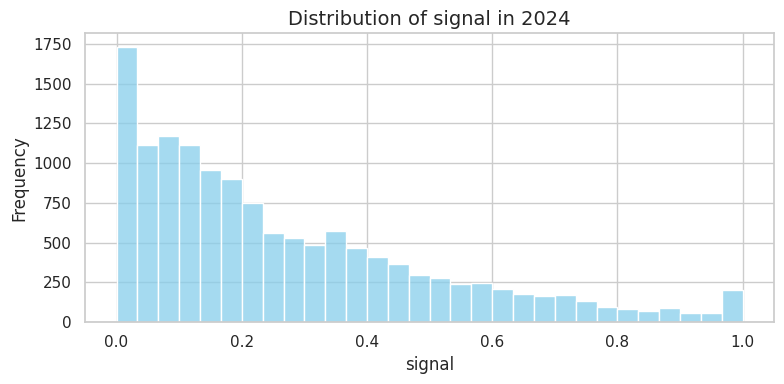

signal_min  signal_max  signal_mean  signal_median  close_return
2024-06         0.0         1.0     0.267377       0.194806      0.150215

In [6]:
pd.set_option('display.max_rows', None)

# Group by month
period = df_fin.index.to_period('M')

# Monthly stats for signal
signal_stats = df_fin.groupby(period)['signal'].agg(
    signal_min='min',
    signal_max='max',
    signal_mean='mean',
    signal_median='median'
)

# Monthly close return: (max - min) / min
close_return = df_fin.groupby(period)['close'].agg(
    close_return=lambda x: np.nan if x.min() == 0 else (x.max() - x.min()) / x.min()
)

# Combine into one DataFrame
monthly_stats = signal_stats.join(close_return)


# --------------------------------------------------
# Now plot histograms of signal for each year
# --------------------------------------------------

sns.set(style="whitegrid")
unique_years = sorted(df_fin.index.year.unique())

for y in unique_years:
    subset = df_fin[df_fin.index.year == y]['signal']
    
    plt.figure(figsize=(8, 4))
    sns.histplot(subset, bins=30, kde=False, color="skyblue")
    plt.title(f"Distribution of signal in {y}", fontsize=14)
    plt.xlabel("signal", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.tight_layout()
    plt.show()

monthly_stats
